#Importing Libraries

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
!pip install surprise
from surprise import Dataset 
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score,classification_report

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Loading Data

In [ ]:
df = pd.read_csv("ratings.csv")
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


# Data preprocessing

In [ ]:
df.isna().sum() #checking for missing value column wise

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [ ]:
dup_bool = df.duplicated(['userId','movieId','rating'])
print("Number of duplicate records:",sum(dup_bool))              #Checking for duplicate records

Number of duplicate records: 0


#Basic data exploration

In [ ]:
print("Total no of ratings :",df.shape[0])
print("No. of unique users:", df["userId"].nunique())
print("No. of unique movies:", df["movieId"].nunique())        #Total number of users,movies and ratings

Total no of ratings : 100836
No. of unique users: 610
No. of unique movies: 9724


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Total number of ratings')

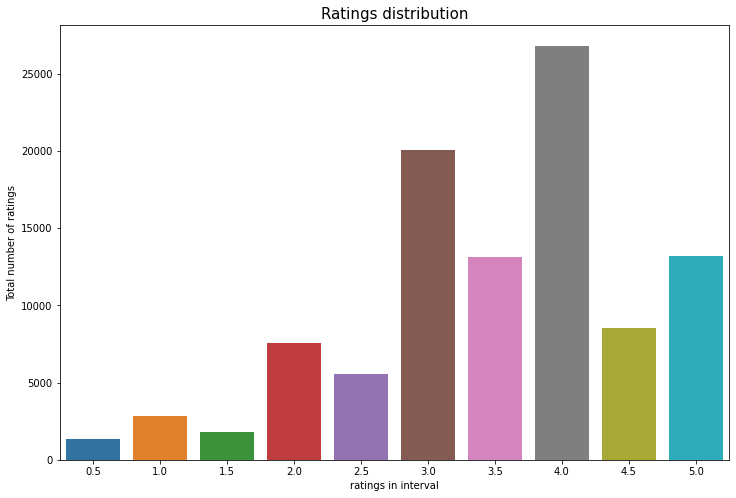

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('Ratings distribution', fontsize=15)
sns.countplot(df['rating'])
ax.set_xlabel("ratings in interval")
ax.set_ylabel("Total number of ratings")                       #Distribution of ratings

In [ ]:
ratings_per_user = df.groupby(by='userId')['rating'].count()#.sort_values(ascending=False)
ratings_per_user.describe()                       #rating per user

count     610.000000
mean      165.304918
std       269.480584
min        20.000000
25%        35.000000
50%        70.500000
75%       168.000000
max      2698.000000
Name: rating, dtype: float64

In [ ]:
ratings_per_movie = df.groupby(by='movieId')['rating'].count()
ratings_per_movie.describe()                #rating per movie

count    9724.000000
mean       10.369807
std        22.401005
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       329.000000
Name: rating, dtype: float64

#Loading as Surprise dataframe and train-test split

In [ ]:
reader = Reader()
ratings = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

Splitting into train and test set

In [ ]:
train_ratings, test_ratings = train_test_split(ratings, test_size=.20, random_state = 42)
print("Size of trainset: ", train_ratings.n_ratings)
print("Size of testset: ", len(test_ratings))

Size of trainset:  80668
Size of testset:  20168


In [ ]:
from surprise import BaselineOnly

In [ ]:
baseline_model = BaselineOnly(verbose = False)
baseline_model.fit(train_ratings)

In [ ]:
train_predictions = baseline_model.test(train_ratings.build_testset())
test_predictions = baseline_model.test(test_ratings)
print("RMSE on training data : ", accuracy.rmse(train_predictions,verbose = False))
print("RMSE on test data: ", accuracy.rmse(test_predictions,verbose = False))

RMSE on training data :  0.8352001301798438
RMSE on test data:  0.8785099023109141


In [ ]:
movies = pd.read_csv("movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
def get_top_n_recommendations(userId,predictions, n=10):
    predict_ratings = {}
    # loop for getting predictions for the user
    for uid, iid, true_r, est, _ in predictions:
        if (uid==userId):
            predict_ratings[iid] = est
    predict_ratings = sorted(predict_ratings.items(), key=lambda kv: kv[1],reverse=True)[:n]
    top_movies = [i[0] for i in predict_ratings]
    top_movies = [str(i) for i in top_movies]
    print("="*10,"Recommended movies for user {} :".format(userId),"="*10)
    print(movies[movies["movieId"].isin(top_movies)]["title"].to_string(index=False))
get_top_n_recommendations(450,test_predictions)

========== Recommended movies for user 450 : ==========

               Sleepless in Seattle
            The Thomas Crown Affair
                    Men in Black II
 Terminator 3: Rise of the Machines

#Using KNNBasic

In [ ]:
from surprise import KNNBasic
knn_model = KNNBasic(random_state = 42,verbose = False)
knn_model.fit(train_ratings)

In [ ]:
#Evaluating the results
train_predictions = knn_model.test(train_ratings.build_testset())
test_predictions = knn_model.test(test_ratings)
print("RMSE on training data : ", accuracy.rmse(train_predictions, verbose = False))
print("RMSE on test data: ", accuracy.rmse(test_predictions, verbose = False))

RMSE on training data :  0.710986894321433
RMSE on test data:  0.9560731582415551


In [ ]:
param_grid = {'k': list(range(10,45,5)),
             'min_k' : list(range(5,11))}
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], return_train_measures = True, cv = 5)
gs.fit(ratings)
gs.best_params['rmse']   #Hyper-parameter tuning to find optimal value of k and min_k

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

{'k': 15, 'min_k': 5}

In [ ]:
 tuned_knn_model = KNNBasic(k = 15, min_k= 5,random_state = 42, verbose = False)
tuned_knn_model.fit(train_ratings)
train_predictions = tuned_knn_model.test(train_ratings.build_testset())
test_predictions = tuned_knn_model.test(test_ratings)
print("RMSE on training data : ", accuracy.rmse(train_predictions, verbose = False))
print("RMSE on test data: ", accuracy.rmse(test_predictions, verbose = False))

RMSE on training data :  0.7338015836306132
RMSE on test data:  0.9472281284806895


#Item-item similarity based


In [ ]:
#Fitting model
knn_model_item_based = KNNBasic(user_based = False, random_state = 42)
knn_model_item_based.fit(train_ratings)

#Evaluating the results
train_predictions = knn_model_item_based.test(train_ratings.build_testset())
test_predictions = knn_model_item_based.test(test_ratings)
print("RMSE on training data : ", accuracy.rmse(train_predictions, verbose = False))
print("RMSE on test data: ", accuracy.rmse(test_predictions, verbose = False))

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE on training data :  0.710986894321433
RMSE on test data:  0.9560731582415551
